<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-and-vision-practices/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
import tensorflow as tf
import os

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = "COMPRESSED"

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
    

#Download images

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


#Visualize

In [5]:
def load_img(path_to_img):
    max_dim = 512
    # Read the file content and returns bytes as string without parsing
    img = tf.io.read_file(path_to_img)
    # Decode the image file content bytes string into uint8
    img = tf.image.decode_image(img, channels=3)
    # Convert image to float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Get image width and height
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    # Expand dimension at axis 0
    img = img[tf.newaxis, :]
    return img 

# Define a simple function to show image
def imshow(image, title=None):
    if len(image.shape) > 3:
        # Remove the first dimension if is 1
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title) 


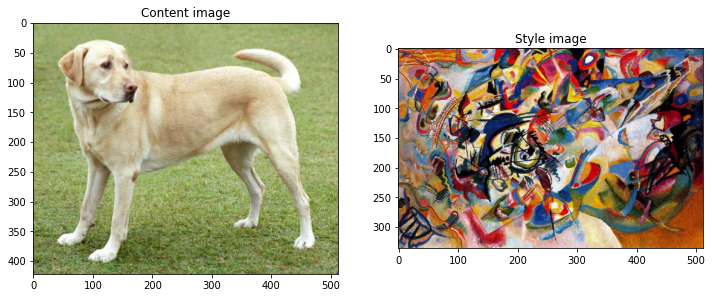

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, "Content image")

plt.subplot(1, 2, 2)
imshow(style_image, "Style image")


#Fast Style transfer using tf-hub

In [7]:
print(type(content_image))
print(content_image.dtype)
print(type(tf.constant(content_image)))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [8]:
import tensorflow_hub as hub

hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")
stylized_image = hub_model(content_image, style_image)[0]


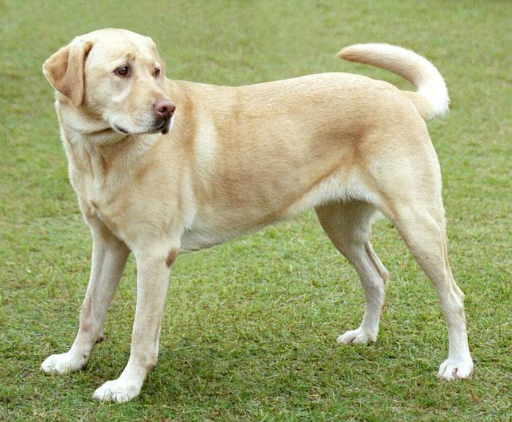

In [9]:
tensor_to_image(content_image)

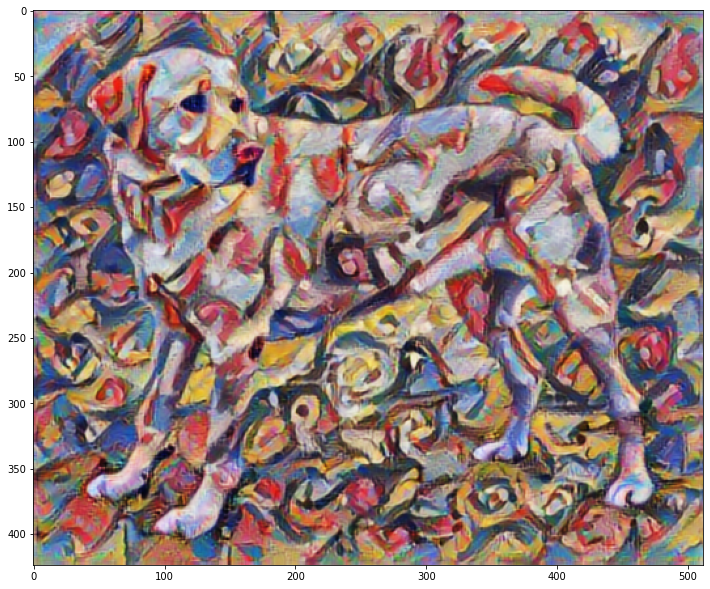

In [10]:
imshow(stylized_image)

In [11]:
import numpy as np

print(np.min(content_image), np.max(content_image))
print(np.min(stylized_image), np.max(stylized_image))

0.0 1.0
0.013041782 0.9791475


In [12]:
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)


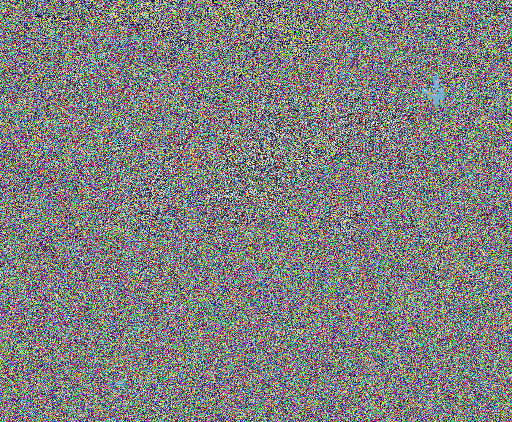

In [13]:
tensor_to_image(x)

In [14]:
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)

574726144/574710816 [==============================] - 4s 0us/step
(1, 1000)


In [15]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('Labrador_retriever', 0.49317124),
 ('golden_retriever', 0.236653),
 ('kuvasz', 0.036357526),
 ('Chesapeake_Bay_retriever', 0.024182705),
 ('Greater_Swiss_Mountain_dog', 0.018646037)]

#Load VGG19 without classification head

In [16]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in vgg.layers:
    print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [17]:
# Choose intermediate layers
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#Build the model

In [18]:
def vgg_layers(layer_names):
    """Create a VGG model that returns a list of intermediate output values."""
    # Load pretrained VGG19 
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [19]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("   shape:   ", output.numpy().shape)
    print("   min:   ", output.numpy().min())
    print("   max:   ", output.numpy().max())
    print("   mean:   ", output.numpy().mean())
    print()
    

block1_conv1
   shape:    (1, 336, 512, 64)
   min:    0.0
   max:    835.5256
   mean:    33.97525

block2_conv1
   shape:    (1, 168, 256, 128)
   min:    0.0
   max:    4625.887
   mean:    199.82687

block3_conv1
   shape:    (1, 84, 128, 256)
   min:    0.0
   max:    8789.237
   mean:    230.78099

block4_conv1
   shape:    (1, 42, 64, 512)
   min:    0.0
   max:    21566.14
   mean:    791.24005

block5_conv1
   shape:    (1, 21, 32, 512)
   min:    0.0
   max:    3189.2537
   mean:    59.179485



#Calculate Style

In [20]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

#Extract style and content

In [21]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        # Expects float inputs in [0, 1]
        inputs = inputs * 255.0
        processed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(processed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output) 
                        for style_output in style_outputs]

        content_dict = {content_name: value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}
        

In [22]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print("Style:")
for name, output in sorted(results['style'].items()):
    print(name)
    print("\tshape:\t", output.numpy().shape)
    print("\tmin:\t", output.numpy().min())
    print("\tmax:\t", output.numpy().max())
    print("\tmean:\t", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print(name)
    print("\tshape:\t", output.numpy().shape)
    print("\tmin:\t", output.numpy().min())
    print("\tmax:\t", output.numpy().max())
    print("\tmean:\t", output.numpy().mean())
    print()


Style:
block1_conv1
	shape:	 (1, 64, 64)
	min:	 0.0055228444
	max:	 28014.557
	mean:	 263.79025

block2_conv1
	shape:	 (1, 128, 128)
	min:	 0.0
	max:	 61479.473
	mean:	 9100.949

block3_conv1
	shape:	 (1, 256, 256)
	min:	 0.0
	max:	 545623.44
	mean:	 7660.9766

block4_conv1
	shape:	 (1, 512, 512)
	min:	 0.0
	max:	 4320505.0
	mean:	 134288.84

block5_conv1
	shape:	 (1, 512, 512)
	min:	 0.0
	max:	 110005.39
	mean:	 1487.0378

Contents:
block5_conv2
	shape:	 (1, 26, 32, 512)
	min:	 0.0
	max:	 2410.8772
	mean:	 13.764149



#Run gradient descent

In [23]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [24]:
image  =tf.Variable(content_image)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


In [25]:
style_weight = 1e-2
content_weight = 1e4

In [26]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss
    

In [27]:
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    

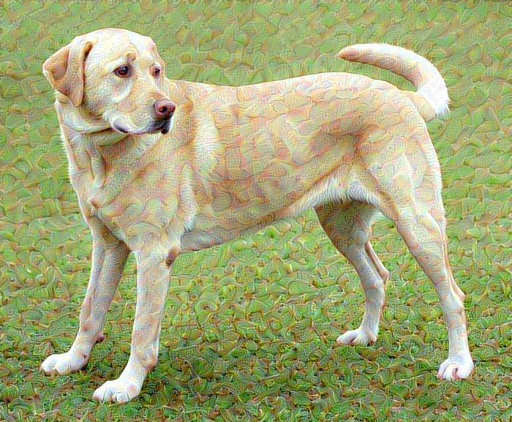

In [28]:
for i in range(3):
    train_step(image)

tensor_to_image(image)

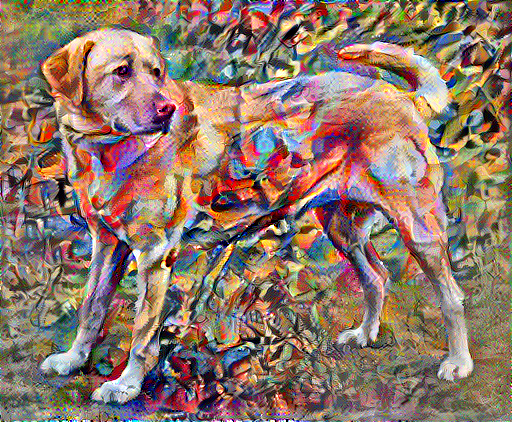

Train Step = 1000
Total time: 258.1


In [30]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100
step = 0
for i in range(epochs):
    for j in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='', flush=True)
    
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train Step = {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


#Total Variation loss

In [31]:
def high_pass_x_y(image):
    x_var = image[:, : , 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

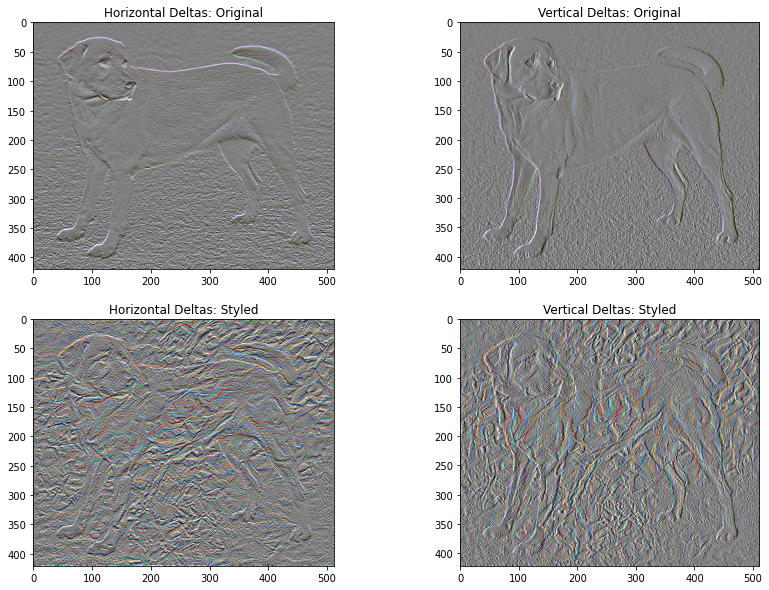

In [32]:
x_delta, y_delta = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_delta+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_delta+0.5), "Vertical Deltas: Original")

x_delta, y_delta = high_pass_x_y(image)
plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_delta+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_delta+0.5), "Vertical Deltas: Styled")

#Sobel image detector

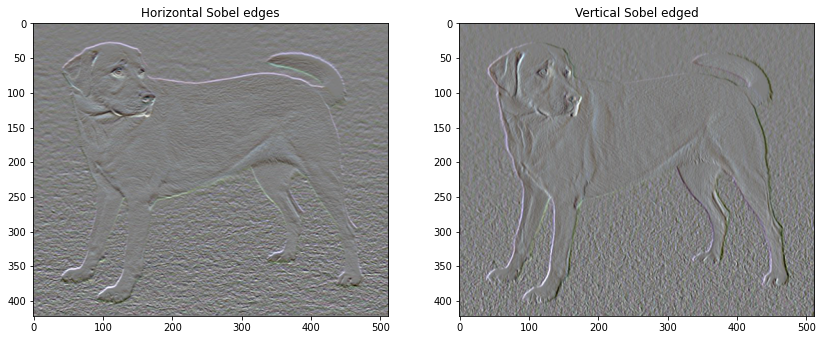

In [33]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel edges")

plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel edged")


In [34]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [35]:
total_variation_loss(image).numpy()

146713.62

In [36]:
tf.image.total_variation(image).numpy()[0]

146713.62

In [37]:
total_variation_weight = 30

In [38]:
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

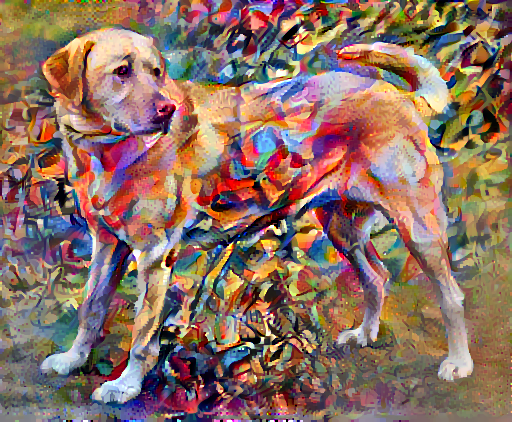

Train Step: 1000
Total time : 259.8


In [39]:
start = time.time()

epochs = 10
steps_per_epochs = 100
step = 0
for m in range(epochs):
    for n in range(steps_per_epochs):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train Step: {}".format(step))

end = time.time()
print("Total time : {:.1f}".format(end - start))

In [40]:
file_name = "stylized_image.png"
tensor_to_image(image).save(file_name)

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

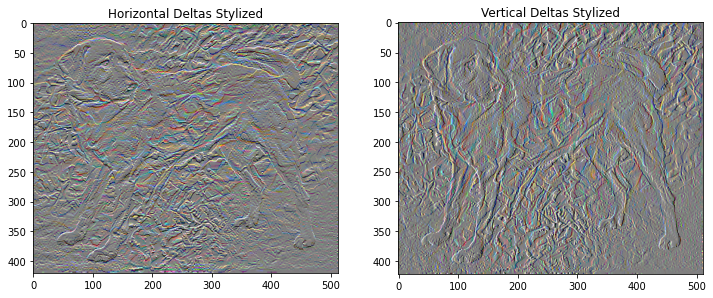

In [41]:
x_deltas, y_deltas = high_pass_x_y(image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas Stylized")

plt.subplot(1, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas Stylized")

In [42]:
total_variation_loss(image).numpy()

55142.367

In [43]:
tf.image.total_variation(image).numpy()[0]

55142.367